In [1]:
import numpy as np
import random
import copy

# 구현체

In [2]:
JOBLESS = 1
MAFIA = 2
POLICE = 3
MEDIC = 4

CITIZEN = 5

POLICE_FORCE = 1.0#경찰한테 발각되었을 때 가중치 
'''
CITIZEN = JOBLIESS + POLICE + MEDIC


마피아 우승 조건: 시민의 수 = 마피아 수 
시민 우승 조건: 마피아 수 = 0 when 시민의 수 > 0
'''

class Mafia_Game:
    def __init__(self, num_of_participant, job_list, is_police_smart):
        self.num_of_participant = num_of_participant
        self.job_list = job_list
        self.is_police_smart = is_police_smart
    
    def initialize_list_for_new_game(self):
        self.before_death = []
        self.weights = []
        self.police_known_mafia = []
        self.alive_mafia = 0
        self.alive_citizen = 0
        self.alive_police = 0
        self.alive_medic = 0
        self.winner = ''

    def get_a_job(self):
        '''
        참가자에게 주어진 직업 수에 맞춰 임의로 직업을 부여한다 
        '''
        self.initialize_list_for_new_game()
        people_job_array = np.ones(self.num_of_participant, dtype=np.int16)
        self.weights = np.ones(self.num_of_participant, dtype=np.float16)
        num_of_mafia = self.job_list[0]
        num_of_police = self.job_list[1]
        num_of_medic = self.job_list[2]
    
        all_job_num = sum(self.job_list)
        
        try:
            choiced_idx = np.array(random.sample(range(0,self.num_of_participant),all_job_num))
        except ValueError:
            print("num of participants is smaller than job_list value")
    
        mafia_idx = np.random.choice(choiced_idx, num_of_mafia, replace=False)
    
        after_choiced_mafia_idx = []
        for idx in choiced_idx:
            if idx not in mafia_idx:
                after_choiced_mafia_idx.append(idx)
    
        police_idx = np.random.choice(after_choiced_mafia_idx, num_of_police, replace=False)
    
        medic_idx = []
        for idx in after_choiced_mafia_idx:
            if idx not in police_idx:
                medic_idx.append(idx)
    
        people_job_array[mafia_idx] = 2
        if len(police_idx) != 0 :
            people_job_array[police_idx] = 3 
        if len(medic_idx) != 0:
            people_job_array[medic_idx] = 4
        return people_job_array, mafia_idx, police_idx, medic_idx    
    
    def kill_during_afternoon(self, participants):
        '''
        이미 죽은 사람을 제외하고, 누구든 죽을 수 있다 
        '''
        alive_person_idx = np.where(participants > 0)[0]
        alive_person_weights = self.weights[alive_person_idx]
        die_person_idx = random.choices(population = alive_person_idx, weights = alive_person_weights , k=1) # 1명 랜덤 제거 
        die_person_job = participants[die_person_idx]
        try:
            die_person_job < 0
        except:
            print('zombie issue during afternoon')
            return None
        participants[die_person_idx] = -die_person_job
        after_death = participants
        self.weights[die_person_idx] = 0
        return after_death, die_person_job[0]
        
    
    def kill_during_night(self, participants):
        '''
        살아있는 시민 중에 한 명이 죽게된다 
        '''
        current_mafia_idx = np.where(participants == MAFIA)[0]
        participants[current_mafia_idx] = 0 #마피아 제외
        alive_participants_idx = np.where(participants > 0)[0] #살아있는 시민의 idx 
        selected_person_idx = np.random.choice(alive_participants_idx, 1)
        die_citizen_idx = selected_person_idx
        die_citizen_job = participants[selected_person_idx]
        try:
            die_citizen_job < 0
        except:
            print('zombie issue during night')
            return None
        participants[die_citizen_idx] = -die_citizen_job
        participants[current_mafia_idx] = MAFIA #마피아 복구 
        after_death = participants
        self.weights[die_citizen_idx] = 0
#         after_death = np.delete(participants, die_citizen_idx)
#         self.weights = np.delete(self.weights, die_citizen_idx)
        return after_death, die_citizen_job[0], die_citizen_idx

    def police_time(self, participants, mafia_idx, police_idx):
        '''
        경찰이 한 명이라도 살아있아면 임의로 한 명을 지목하여 직업을 확인할 수 있다. 
        만약 마피아를 확인했다면, 해당 마피아의 지목 가중치가 1 증가한다 
        경찰이 선택했던 마피아를 또 선택하는 경우와, 
        선택한 마피아를 제외하고 선택하는 경우로 나뉜다. 
        이는 is_police_smart의 여부에 따라 달라진다 
        '''
        #경찰이 살아있을 때
        if self.alive_police > 0: 
            participants[police_idx] = 0 #경찰끼리 서로 안다 
            if self.is_police_smart and len(self.police_known_mafia) >0 :
                participants[self.police_known_mafia] = 0 #이미 확인한 마피아 제외 
            alive_participants = np.where(participants >0)[0]
            if len(alive_participants) == 0:
                return
            selected_person_idx = np.random.choice(alive_participants, 1)
            if participants[selected_person_idx] == MAFIA:
                if selected_person_idx not in self.police_known_mafia:
                    self.police_known_mafia.append(selected_person_idx[0])
                    self.weights[selected_person_idx] += POLICE_FORCE
        return
    
    def medic_time(self, participants, choiced_citizen_idx, medic_idx):
        if self.alive_medic > 0:
            '''
            메딕은 서로 치료할 수 있다. 물론 마피아를 선택할 수 있다. 
            하지만 밤에는 시민만 죽기 때문에 밤에 지목당한 시민을 선택했을 때 (무직, 경찰, 메딕) 중 누구라도 살릴 수 있다 
            '''
            medic_choice_idx = np.random.choice(len(participants), 1)
            if choiced_citizen_idx == medic_choice_idx:
                self.before_death[choiced_citizen_idx] = -(self.before_death[choiced_citizen_idx])
                self.weights[choiced_citizen_idx] = 1
        
    def update(self, job):
        if job == MAFIA:
            self.alive_mafia -= 1
        else:
            self.alive_citizen -= 1
            if job == POLICE:
                self.alive_police -= 1
            elif job == MEDIC:
                self.alive_medic -= 1
            else:
                pass

    def run(self):
        participants, mafia, police, medic = self.get_a_job()
        self.before_death = participants
        self.alive_mafia = len(mafia)
        self.alive_police = len(police)
        self.alive_medic = len(medic)
        self.alive_citizen = len(participants) - len(mafia)
        
        while True:
            next_day = copy.deepcopy(self.before_death)
            
            after_afternoon, job = self.kill_during_afternoon(next_day)
            self.update(job)
            self.before_death = after_afternoon
            
            before_night = copy.deepcopy(self.before_death)

            after_night, job, choiced_citizen_idx = self.kill_during_night(before_night)
            self.update(job)
            self.before_death = after_night
            
            before_police_time = copy.deepcopy(self.before_death)

            self.police_time(before_police_time, mafia, police)
            
            before_medic_time = copy.deepcopy(self.before_death)
            
            self.medic_time(before_medic_time, choiced_citizen_idx, medic)
            
            if self.alive_mafia == 0:
                self.winner = CITIZEN
                break 
            elif self.alive_citizen <= self.alive_mafia:
                self.winner = MAFIA
                break
            else:
                pass
#                 print('next day')
    
        return self.winner

# 기본 모델 사용 예시

In [3]:
'''
기본 모델 사용 예시 
'''

mafia_game = Mafia_Game(10,[2,1,1],False)


mafia_win_percentage_list = []
citizen_win_percentage_list = []

for _ in range(1,101):
    '''
    평균 승률 계산을 위한 100번의 실행 
    '''
    mafia_win = 0
    citizen_win = 0
    for _ in range(1,101):
        '''
        마피아 게임 100판
        '''
        rtn = mafia_game.run()
        if rtn == CITIZEN:
            citizen_win += 1
        else:
            mafia_win +=1 
    
    mafia_win_percentage = mafia_win / (mafia_win + citizen_win)
    citizen_win_percentage = citizen_win / (mafia_win + citizen_win)
#     print('mafia win percentage: ', mafia_win_percentage)
#     print('citizen win percentage: ', citizen_win_percentage)
        
    mafia_win_percentage_list.append(mafia_win_percentage)
    citizen_win_percentage_list.append(citizen_win_percentage)

mean_mafia_win_percentage = np.array(mafia_win_percentage_list).mean()
mean_citizen_win_percentage = np.array(citizen_win_percentage_list).mean()

print('mean_mafia_win_percentage: ', mean_mafia_win_percentage)
print('mean_citizen_win_percentage: ', mean_citizen_win_percentage)

mean_mafia_win_percentage:  0.7493
mean_citizen_win_percentage:  0.2507



# 마피아와 시미만 존재할 때 마피아 수에 따른 변화

In [78]:
'''
마피아와 시민만 존재할 때, 마피아 수에 의한 마피아 승률 
'''

mafia_win_percentage_by_mafia_num = dict()
mafia_win_percentage_list_by_mafia_num = dict()

for mafia_num in range(1,10):
    mafia_game = Mafia_Game(20,[mafia_num,0,0],False)


    mafia_win_percentage_list = []
    citizen_win_percentage_list = []

    for _ in range(1,101):
        mafia_win = 0
        citizen_win = 0
        for _ in range(1,101):
            rtn = mafia_game.run()
            if rtn == CITIZEN:
                citizen_win += 1
            else:
                mafia_win +=1 
    
        mafia_win_percentage = mafia_win / (mafia_win + citizen_win)
        citizen_win_percentage = citizen_win / (mafia_win + citizen_win)
        
        mafia_win_percentage_list.append(mafia_win_percentage)
        citizen_win_percentage_list.append(citizen_win_percentage)
        

    mafia_win_percentage_list_by_mafia_num[mafia_num] = mafia_win_percentage_list
    mean_mafia_win_percentage = np.array(mafia_win_percentage_list).mean()
    mean_citizen_win_percentage = np.array(citizen_win_percentage_list).mean()

    print('-------------mafia_num : ',mafia_num, '마피아 승률','--------------------')
    print('mean_mafia_win_percentage: ', mean_mafia_win_percentage)
    print('mean_citizen_win_percentage: ', mean_citizen_win_percentage)
    mafia_win_percentage_by_mafia_num[mafia_num] = mean_mafia_win_percentage
    
print('\n',mafia_win_percentage_by_mafia_num)
# print('\n',mafia_win_percentage_list_by_mafia_num)

-------------mafia_num :  1 평균승률 --------------------
mean_mafia_win_percentage:  0.34580000000000005
mean_citizen_win_percentage:  0.6542
-------------mafia_num :  2 평균승률 --------------------
mean_mafia_win_percentage:  0.5994
mean_citizen_win_percentage:  0.4005999999999999
-------------mafia_num :  3 평균승률 --------------------
mean_mafia_win_percentage:  0.7712
mean_citizen_win_percentage:  0.2288
-------------mafia_num :  4 평균승률 --------------------
mean_mafia_win_percentage:  0.8753
mean_citizen_win_percentage:  0.1247
-------------mafia_num :  5 평균승률 --------------------
mean_mafia_win_percentage:  0.9411999999999999
mean_citizen_win_percentage:  0.05879999999999999
-------------mafia_num :  6 평균승률 --------------------
mean_mafia_win_percentage:  0.9814000000000002
mean_citizen_win_percentage:  0.018600000000000002
-------------mafia_num :  7 평균승률 --------------------
mean_mafia_win_percentage:  0.9941
mean_citizen_win_percentage:  0.005900000000000001
-------------mafia_num :  8 

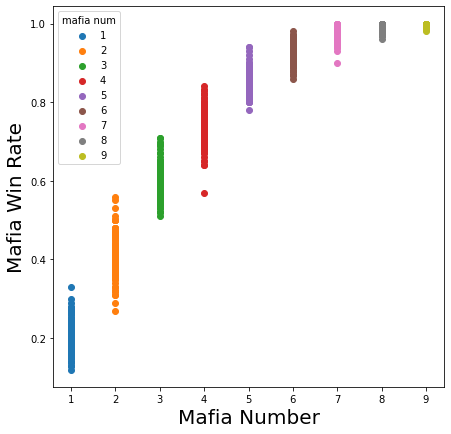

In [135]:
import matplotlib.pyplot as plt

from importlib import reload

plt.figure(figsize=(7,7))
plt.rc('axes', labelsize=20) 

for key, value in mafia_win_percentage_list_by_mafia_num.items():
    plt.scatter(x=np.full((1,len(value)), key, dtype=int), y=value)

plt.legend(mafia_win_percentage_list_by_mafia_num.keys(), title="mafia num")
plt.xlabel("Mafia Number")
plt.ylabel("Mafia Win Rate")
plt.show()



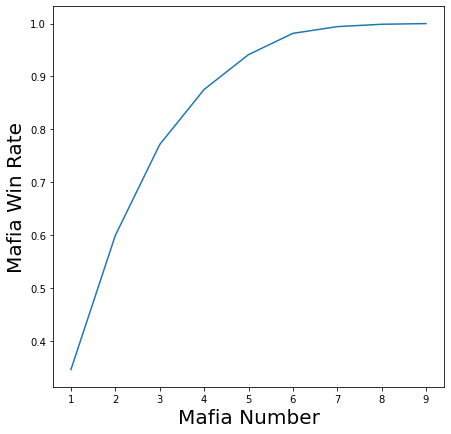

In [80]:
lists = sorted(mafia_win_percentage_by_mafia_num.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(7,7))
plt.rc('axes', labelsize=20) 
plt.xlabel("Mafia Number")
plt.ylabel("Mafia Win Rate")
plt.plot(x, y)
plt.show()


# 마피아, 경찰, 일반 시민이 있을 때 
## 경찰이 지목한 마피아를 기억하지 못하는 경우

In [142]:
'''
여기서부터는 마피아의 평균 승률만 관찰 
'''
mafia_win_percentage_by_stupid_police_num = dict() # 마피아의 평균 승률을 기록하기 위함 

for police_num in range(0,12):

    mafia_win_percentage_by_mafia_num = dict()
    mafia_win_percentage_list_by_mafia_num = dict()

    for mafia_num in range(1,10):
        mafia_game = Mafia_Game(20,[mafia_num,police_num,0],False)


        mafia_win_percentage_list = []
        citizen_win_percentage_list = []

        for _ in range(1,101):
            mafia_win = 0
            citizen_win = 0
            for _ in range(1,101):
                rtn = mafia_game.run()
                if rtn == CITIZEN:
                    citizen_win += 1
                else:
                    mafia_win +=1 
    
            mafia_win_percentage = mafia_win / (mafia_win + citizen_win)
            citizen_win_percentage = citizen_win / (mafia_win + citizen_win)
        
            mafia_win_percentage_list.append(mafia_win_percentage)
            citizen_win_percentage_list.append(citizen_win_percentage)
        

        mafia_win_percentage_list_by_mafia_num[mafia_num] = mafia_win_percentage_list
        mean_mafia_win_percentage = np.array(mafia_win_percentage_list).mean()
        mean_citizen_win_percentage = np.array(citizen_win_percentage_list).mean()
        mafia_win_percentage_by_mafia_num[mafia_num] = mean_mafia_win_percentage
    
    print("------------------",'police_num: ',police_num,' 마피아 평균승률------------------')
    print('\n',mafia_win_percentage_by_mafia_num)
    mafia_win_percentage_by_stupid_police_num[police_num] = mafia_win_percentage_by_mafia_num
print(mafia_win_percentage_by_stupid_police_num)

------------------ police_num:  0  마피아 평균승률------------------

 {1: 0.3531, 2: 0.6072000000000001, 3: 0.7775, 4: 0.8814000000000002, 5: 0.9465999999999998, 6: 0.9789999999999999, 7: 0.9939, 8: 0.9987999999999999, 9: 1.0}
------------------ police_num:  1  마피아 평균승률------------------

 {1: 0.29359999999999997, 2: 0.5347, 3: 0.7164999999999998, 4: 0.8389, 5: 0.9207000000000001, 6: 0.9651000000000001, 7: 0.9872, 8: 0.9976, 9: 0.9986999999999999}
------------------ police_num:  2  마피아 평균승률------------------

 {1: 0.2815, 2: 0.4997, 3: 0.6855999999999999, 4: 0.8136, 5: 0.9073, 6: 0.96, 7: 0.9840000000000002, 8: 0.9967999999999999, 9: 0.9995}
------------------ police_num:  3  마피아 평균승률------------------

 {1: 0.26870000000000005, 2: 0.4927, 3: 0.6653999999999999, 4: 0.8104, 5: 0.8960000000000002, 6: 0.9541, 7: 0.9841, 8: 0.9969, 9: 0.9993000000000001}
------------------ police_num:  4  마피아 평균승률------------------

 {1: 0.2584, 2: 0.48269999999999996, 3: 0.6595, 4: 0.7935, 5: 0.8876000000000001

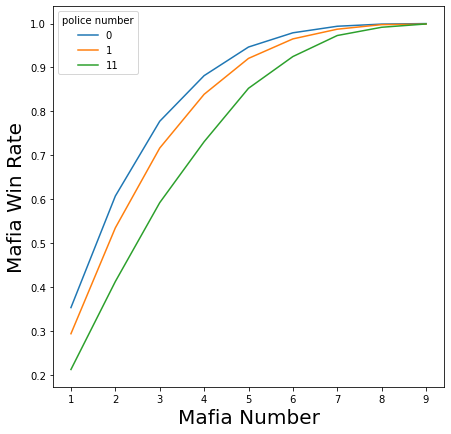

In [143]:
plt.figure(figsize=(7,7))
plt.rc('axes', labelsize=20) 
plt.xlabel("Mafia Number")
plt.ylabel("Mafia Win Rate")


for police_num, mafia_mean_win_rate in mafia_win_percentage_by_stupid_police_num.items():
    lists = sorted(mafia_mean_win_rate.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    
    if police_num ==0 or police_num ==1 or police_num == 11:
        plt.plot(x, y, label=police_num)


plt.legend(title='police number')
plt.show()
plt.close()

## 경찰이 지목한 마피아를 기억할 때 

In [145]:
mafia_win_percentage_by_smart_police_num = dict() # 마피아의 평균 승률을 기록하기 위함 

for police_num in range(0,12):

    mafia_win_percentage_by_mafia_num = dict()
    mafia_win_percentage_list_by_mafia_num = dict()

    for mafia_num in range(1,10):
        mafia_game = Mafia_Game(20,[mafia_num,police_num,0],True)


        mafia_win_percentage_list = []
        citizen_win_percentage_list = []

        for _ in range(1,101):
            mafia_win = 0
            citizen_win = 0
            for _ in range(1,101):
                rtn = mafia_game.run()
                if rtn == CITIZEN:
                    citizen_win += 1
                else:
                    mafia_win +=1 
    
            mafia_win_percentage = mafia_win / (mafia_win + citizen_win)
            citizen_win_percentage = citizen_win / (mafia_win + citizen_win)
        
            mafia_win_percentage_list.append(mafia_win_percentage)
            citizen_win_percentage_list.append(citizen_win_percentage)
        

        mafia_win_percentage_list_by_mafia_num[mafia_num] = mafia_win_percentage_list
        mean_mafia_win_percentage = np.array(mafia_win_percentage_list).mean()
        mean_citizen_win_percentage = np.array(citizen_win_percentage_list).mean()
        mafia_win_percentage_by_mafia_num[mafia_num] = mean_mafia_win_percentage
    
    print("------------------",'police_num: ',police_num,' 마피아 평균승률------------------')
    print('\n',mafia_win_percentage_by_mafia_num)
    mafia_win_percentage_by_smart_police_num[police_num] = mafia_win_percentage_by_mafia_num
print(mafia_win_percentage_by_smart_police_num)

------------------ police_num:  0  마피아 평균승률------------------

 {1: 0.35359999999999997, 2: 0.6033000000000001, 3: 0.7767000000000001, 4: 0.8802, 5: 0.9458, 6: 0.9773, 7: 0.9927000000000001, 8: 0.9987999999999999, 9: 0.9996}
------------------ police_num:  1  마피아 평균승률------------------

 {1: 0.29120000000000007, 2: 0.5367999999999999, 3: 0.7099000000000001, 4: 0.8348, 5: 0.9162000000000002, 6: 0.9621999999999998, 7: 0.9885, 8: 0.9967, 9: 0.9994}
------------------ police_num:  2  마피아 평균승률------------------

 {1: 0.28730000000000006, 2: 0.5095000000000001, 3: 0.6785, 4: 0.8140999999999998, 5: 0.9081, 6: 0.9600000000000002, 7: 0.9851000000000001, 8: 0.9949000000000001, 9: 0.9994}
------------------ police_num:  3  마피아 평균승률------------------

 {1: 0.26099999999999995, 2: 0.4851, 3: 0.6729999999999999, 4: 0.8027, 5: 0.8905000000000001, 6: 0.9501999999999999, 7: 0.9825, 8: 0.9956999999999999, 9: 0.9996}
------------------ police_num:  4  마피아 평균승률------------------

 {1: 0.2599, 2: 0.4815000

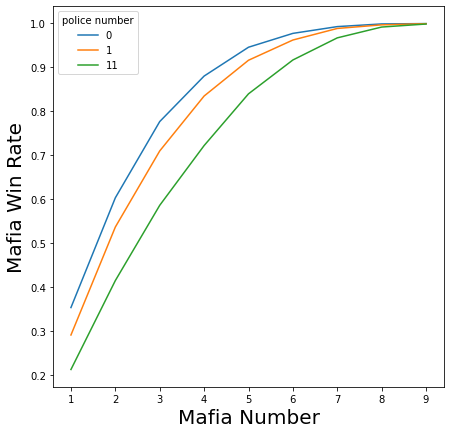

In [146]:
plt.figure(figsize=(7,7))
plt.rc('axes', labelsize=20) 
plt.xlabel("Mafia Number")
plt.ylabel("Mafia Win Rate")


for police_num, mafia_mean_win_rate in mafia_win_percentage_by_smart_police_num.items():
    lists = sorted(mafia_mean_win_rate.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    
    if police_num ==0 or police_num ==1 or police_num == 11:
        plt.plot(x, y, label=police_num)


plt.legend(title='police number')
plt.show()
plt.close()

# 경찰이 똑똑할 때와 아닐 때 비교 

{1: 0.2127, 2: 0.4150000000000001, 3: 0.5861999999999999, 4: 0.7221000000000002, 5: 0.8397999999999999, 6: 0.9168000000000001, 7: 0.9670999999999998, 8: 0.9916999999999999, 9: 0.9986000000000002} 

{1: 0.21210000000000004, 2: 0.4125000000000001, 3: 0.5921, 4: 0.7309, 5: 0.8526, 6: 0.9249, 7: 0.9728, 8: 0.9915999999999999, 9: 0.9991} 



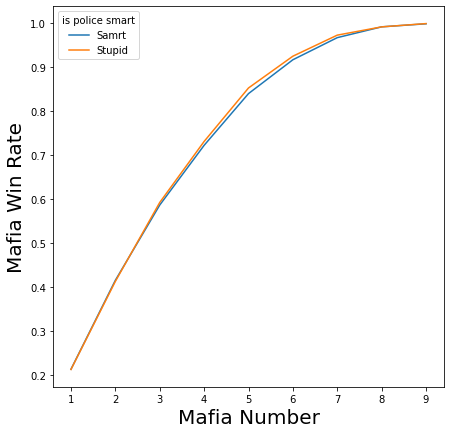

In [193]:
compare_police_intellect = dict ()

for i in range(0,(len(mafia_win_percentage_by_smart_police_num))):
    compare_police_intellect[i] = [mafia_win_percentage_by_smart_police_num[i], mafia_win_percentage_by_stupid_police_num[i]]
    
compare_police_num_11 = compare_police_intellect[11]
compare_police_num_5 = compare_police_intellect[5]
compare_police_num_1 = compare_police_intellect[1]

# print(compare_police_num_5)

plt.figure(figsize=(7,7))
plt.rc('axes', labelsize=20) 
plt.xlabel("Mafia Number")
plt.ylabel("Mafia Win Rate")

is_police_smart = 'Samrt'

for percent_dict in compare_police_num_11:
    print(percent_dict, '\n')
    lists = sorted(percent_dict.items())
    x, y = zip(*lists)
    plt.plot(x, y, label = is_police_smart)
    is_police_smart = 'Stupid'

plt.legend(title="is police smart")
plt.show()    



In [157]:
for i in range(1,10):
    print(i)

1
2
3
4
5
6
7
8
9
